In [36]:
import numpy as np
import pandas as pd
import os

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sb

In [37]:
data = pd.read_csv('./data/winequality-red.csv', delimiter=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [38]:
from sklearn.preprocessing import OneHotEncoder

In [58]:
binary_data = data.copy()
binary_data['quality'] = binary_data['quality'].apply(lambda x: 1 if x > 5 else 0)

binary_data.quality.value_counts()

1    855
0    744
Name: quality, dtype: int64

$$ P(Y=1) = p, \  P(Y=0) = q \equiv 1-p $$
$$odds(p,q) = \frac{p}{q} = \frac{p}{1-p} $$

In [63]:
def odds(p):
    return (p + 1e-8) / (1-p + 1e-8)

def log_odds(p):
    return np.log(odds(p))

In [64]:
x = np.arange(0, 1, 1e-3)
x[:10]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009])

In [65]:
odds_x = odds(x)
log_odds_x = log_odds(x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


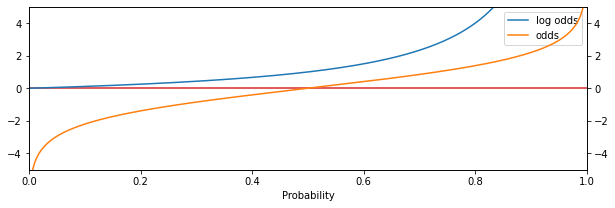

In [66]:
fig, ax = plt.subplots(1,1, figsize = (10, 3))

ax.axhline(0, color = 'tab:red')

ax.plot(x, odds_x)
ax.set_ylim(-5, 5)
ax.set_xlim(0, 1)

tax = ax.twinx()
tax.plot(x, log_odds_x, color = 'tab:orange')
tax.set_ylim(-5, 5)
ax.legend()

ax.legend(
    [
        matplotlib.lines.Line2D([],[],color = 'tab:blue'),
        matplotlib.lines.Line2D([],[],color = 'tab:orange'),
    ], 
    [
        'log odds',
        'odds'
    ])

ax.set_xlabel('Probability')
fig.show()

$$y = f(x,\beta) = \log \frac{p}{1-p}$$

$$x = [1,x_{1},x_{2},\cdots,x_{k}]$$

$$\beta = [\beta_0, \beta_1, \beta_2, \cdots, \beta_k]$$
 
$$y = \log \frac{p}{1-p} \approx x_{0} \beta_0 + x_{1} \beta_1 + x_{2} \beta_2 + \cdots + x_{k} \beta_k = \sum_{i=0}^{k} x_i \beta_i = x \beta  $$

$$ \therefore \beta = (x^T x)^{-1}x^T y = (x^T x)^{-1}x^T \log \frac{p}{1-p}$$

In [69]:
data_x = binary_data.iloc[:, :-1]
data_y = binary_data.iloc[:, -1]

In [72]:
data_y

0       0
1       0
2       0
3       1
4       0
       ..
1594    0
1595    1
1596    1
1597    0
1598    1
Name: quality, Length: 1599, dtype: int64

In [73]:
def logisticLinearRegression(x,y):
    xt_dot_x = np.dot(x.transpose(), x)
    inverse_xt_dot_x = np.linalg.inv(xt_dot_x + 1e-8)
    beta = inverse_xt_dot_x @ x.transpose() @ log_odds(y)
    return beta

beta = logisticLinearRegression(data_x,data_y)
beta = beta.rename(
    index = {i:j for i,j in zip(beta.index, data_x.columns)}
)
for k,v in beta.items():
    print(f'{k}:\t {v:.4g}')

fixed acidity:	 0.6411
volatile acidity:	 -21
citric acid:	 -6.995
residual sugar:	 0.1902
chlorides:	 -29.14
free sulfur dioxide:	 0.1664
total sulfur dioxide:	 -0.1166
density:	 -47.62
pH:	 -3.647
sulphates:	 18.58
alcohol:	 5.86


In [75]:
from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def kfold_fn(data, scaling = True):
    kf = KFold()
    for n, (train_idx, valid_idx) in enumerate(kf.split(data)):
        
        scaler_x = StandardScaler()
#         scaler_y = StandardScaler()
        
        if scaling:
            train_x = scaler_x.fit_transform(data.iloc[train_idx].drop(columns = 'quality'))
            valid_x = scaler_x.transform(data.iloc[valid_idx].drop(columns = 'quality'))
            
        else:
            train_x = data.iloc[train_idx].drop(columns = 'quality').values
            valid_x = data.iloc[valid_idx].drop(columns = 'quality').values

        train_y = data.iloc[train_idx]['quality'].values.reshape(-1,1)
        valid_y = data.iloc[valid_idx]['quality'].values.reshape(-1,1)
        
        yield [
            [train_x, train_y],
            [valid_x, valid_y]
        ], (scaler_x)

        
def logistic_reg(x, beta):
    return 1 / (1 + np.exp(x @ beta))


scalers = []
betas = []
valid_y_hat = []
valid_y = []
for (train_set, valid_set), scaler in kfold_fn(binary_data):
    scalers.append(scaler)
    beta = logisticLinearRegression(*train_set)
    betas.append(beta)
    valid_y.append(valid_set[1])
    valid_y_hat.append(logistic_reg(valid_set[0], beta))
    


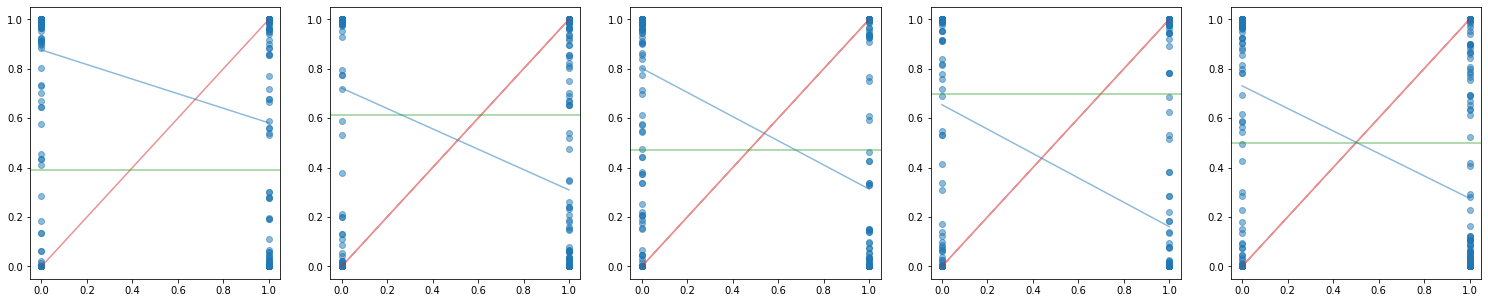

In [76]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,5, figsize = (26, 5))

for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    ax[n].scatter(yt, yp, alpha = .5)
    ax[n].plot(yt,yt, color = 'tab:red', alpha = .5)
    ax[n].plot([0,1],[yp[yt == 0].mean(),yp[yt == 1].mean()], color = 'tab:blue', alpha = .5)
    ax[n].axhline(yt.mean(), color = 'tab:green', alpha = .5)

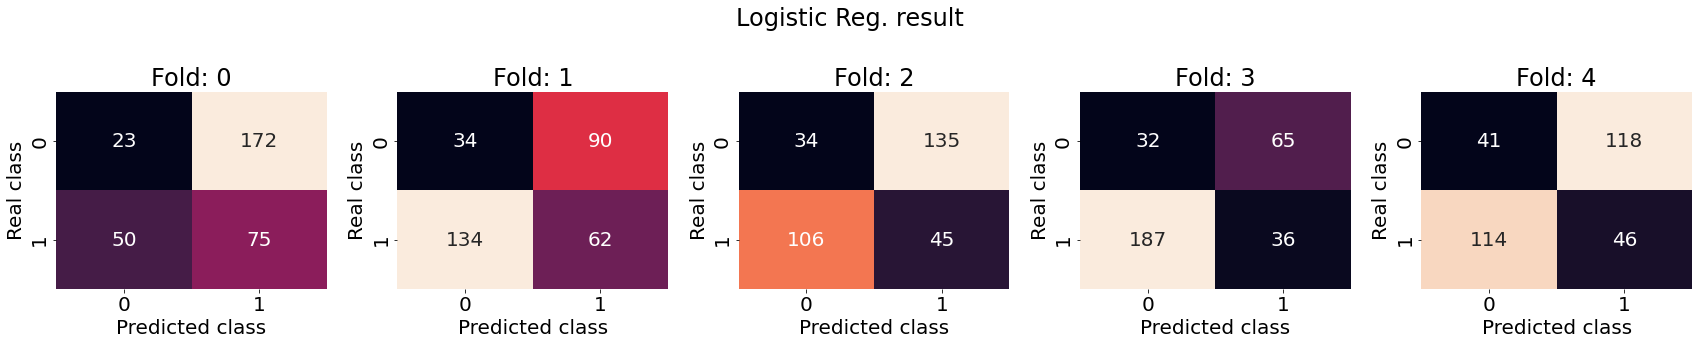

In [78]:
def vis_clf(yt, yp):

    round_yp = yp.round()
    match_matrix = np.zeros((2,2))
    for y_true_value, y_pred_value in product(range(2), range(2)):

        count_value = ((yt == y_true_value) & (round_yp == y_pred_value)).sum()
        match_matrix[y_true_value, y_pred_value] += count_value

    return match_matrix

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,5,figsize = (24,5))

for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    matrix = vis_clf(yt, yp)
    sb.heatmap(matrix, ax = ax[n], cbar = False, annot = matrix, fmt = '.0f')
    ax[n].set_title(f'Fold: {n}')
    ax[n].set_ylabel('Real class')
    ax[n].set_xlabel('Predicted class')

fig.suptitle('Logistic Reg. result')    
fig.tight_layout()